## In this notebook we are going to do an analysis on a Boston airbnb dataset, in order to answer those three main questions <br>
>1- What are the aspects of a listing that best correlate to price ?
<br>2- What are the aspects of a listing that best correlate to availabilty (lack of bookings), and if found (those aspects), do they necessarily correlate  with fully booked listings ?
<br>3- What are the features that best correlate to a superhost ?


# Notebook sections:
## # 1- [Imports and EDA](#section_1)
## # 2- [Cleaning and processing](#section_2)
## # 3- [Visualizing correlations](#section_3)



> We start with importing needed libraries 

<a id="section_1"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import urllib
from selenium.webdriver.chrome.service import Service
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
Boston_listings = pd.read_csv('Boston_listings.csv')

In [3]:
Boston_listings

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3168,https://www.airbnb.com/rooms/3168,20220915162158,2022-09-15,city scrape,TudorStudio,"The ""Studio at 14 Weldon"" is located in Newton...","Newton has 13 unique villages, and gives off a...",https://a0.muscache.com/pictures/ff7952dc-ef0b...,3697,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
1,3781,https://www.airbnb.com/rooms/3781,20220915162158,2022-09-15,city scrape,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,"Mostly quiet ( no loud music, no crowed sidewa...",https://a0.muscache.com/pictures/24670/b2de044...,4804,...,4.96,4.87,4.91,NaN,f,1,1,0,0,0.26
2,5506,https://www.airbnb.com/rooms/5506,20220915162158,2022-09-15,city scrape,** Fort Hill Inn Private! Minutes to center!**,"Private guest room with private bath, You do n...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/miso/Hosting-...,8229,...,4.89,4.54,4.73,Approved by the government,f,10,10,0,0,0.69
3,6695,https://www.airbnb.com/rooms/6695,20220915162158,2022-09-15,city scrape,"Fort Hill Inn *Sunny* 1 bedroom, condo duplex","Comfortable, Fully Equipped private apartment...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,...,4.95,4.50,4.71,STR446650,f,10,10,0,0,0.75
4,7903,https://www.airbnb.com/rooms/7903,20220915162158,2022-09-15,city scrape,"Colorful, modern 2 BR apt shared with host",I'm a high school teacher and frequent travele...,"The apartment is in Somerville, located direct...",https://a0.muscache.com/pictures/miso/Hosting-...,14169,...,4.95,4.56,4.80,NaN,f,1,0,1,0,1.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5180,716081443145047239,https://www.airbnb.com/rooms/716081443145047239,20220915162158,2022-09-15,city scrape,Private Room with Shared Bath in Quiet Street,*Please Note: You are booking a private room i...,South Boston is a very large neighborhood comp...,https://a0.muscache.com/pictures/prohost-api/H...,2356643,...,NaN,NaN,NaN,STR-460218,f,71,25,46,0,NaN
5181,716081469166085329,https://www.airbnb.com/rooms/716081469166085329,20220915162158,2022-09-15,city scrape,Cozy Bedroom in Convenient Downtown Location,*Please Note: You are booking a private room i...,South Boston is a very large neighborhood comp...,https://a0.muscache.com/pictures/prohost-api/H...,2356643,...,NaN,NaN,NaN,STR-460218,f,71,25,46,0,NaN
5182,716081495310456299,https://www.airbnb.com/rooms/716081495310456299,20220915162158,2022-09-15,city scrape,"Peaceful Bedroom w/ Shared Bath - AC, Wifi inc...",*Please Note: You are booking a private room i...,South Boston is a very large neighborhood comp...,https://a0.muscache.com/pictures/prohost-api/H...,2356643,...,NaN,NaN,NaN,STR-460218,f,71,25,46,0,NaN
5183,716235197792512391,https://www.airbnb.com/rooms/716235197792512391,20220915162158,2022-09-15,city scrape,Sunny Room w/ Shared Bath in Modest Brighton Home,"Perfect for Hospital Stays, Medical Students, ...",The apartment is located in a walkable neighbo...,https://a0.muscache.com/pictures/prohost-api/H...,2356643,...,NaN,NaN,NaN,STR-484106,t,71,25,46,0,NaN


In [5]:
Boston_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5185 entries, 0 to 5184
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            5185 non-null   int64  
 1   listing_url                                   5185 non-null   object 
 2   scrape_id                                     5185 non-null   int64  
 3   last_scraped                                  5185 non-null   object 
 4   source                                        5185 non-null   object 
 5   name                                          5185 non-null   object 
 6   description                                   5140 non-null   object 
 7   neighborhood_overview                         3435 non-null   object 
 8   picture_url                                   5185 non-null   object 
 9   host_id                                       5185 non-null   i

### After a quick data exploration, we need to drop a couple of columns, which are:
> 1- Columns that are mostly null or all null, although nothing of those columns are dropped if it can be scraped as we will see later in the notebook <br>
2- Personal info (Id) <br>
3- Non-relevant info (urls, yet listing_url is needed to validate some of the data as we will see later in the notebook) <br>
4- Meta-data (source) <br>
5- String columns (i.e. those that need TF-IDF) for simplicity


<a id="section_2"></a>

In [6]:
Boston_listings.drop(columns=['id', 'name', 'description', 'last_scraped', 'scrape_id',
                                'host_name', 'host_about', 'host_neighbourhood', 'amenities',
                                'source','picture_url', 'first_review', 'last_review', 'review_scores_rating',
                                'review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin',
                                'review_scores_communication','review_scores_location', 'review_scores_value',
                                'review_scores_value', 'license', 'host_id', 'host_url','host_thumbnail_url',
                                'host_picture_url','calendar_updated','bathrooms','neighbourhood_group_cleansed',
                             'neighbourhood', 'neighborhood_overview'],
                    inplace=True)


In [7]:
Boston_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5185 entries, 0 to 5184
Data columns (total 45 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_url                                   5185 non-null   object 
 1   host_since                                    5185 non-null   object 
 2   host_location                                 4485 non-null   object 
 3   host_response_time                            4575 non-null   object 
 4   host_response_rate                            4575 non-null   object 
 5   host_acceptance_rate                          4635 non-null   object 
 6   host_is_superhost                             5182 non-null   object 
 7   host_listings_count                           5185 non-null   int64  
 8   host_total_listings_count                     5185 non-null   int64  
 9   host_verifications                            5185 non-null   o

In [8]:

one_hot = pd.get_dummies(Boston_listings['neighbourhood_cleansed'])

Boston_listings = Boston_listings.drop('neighbourhood_cleansed',axis = 1)

Boston_listings = Boston_listings.join(one_hot)

# =================================================================

one_hot = pd.get_dummies(Boston_listings['host_location'], dummy_na=True, prefix='host_location')

Boston_listings = Boston_listings.drop('host_location',axis = 1)

Boston_listings = Boston_listings.join(one_hot)


# =================================================================


one_hot = pd.get_dummies(Boston_listings['bathrooms_text'], dummy_na=True, prefix='bathrooms_text')

Boston_listings = Boston_listings.drop('bathrooms_text',axis = 1)

Boston_listings = Boston_listings.join(one_hot)



# =================================================================


Boston_listings['host_response_rate'] = Boston_listings['host_response_rate'].str.rstrip('%').astype('float')


# =================================================================


Boston_listings['host_acceptance_rate'] = Boston_listings['host_acceptance_rate'].str.rstrip('%').astype('float')


# =================================================================



Boston_listings['price'] = Boston_listings['price'].str.strip('$').str.replace(',', '').astype('float')


> The *listing url* that corresponds to null values of the column `bedrooms` suggest that those nulls mean *zero* or *no actuall bedroom*.

In [9]:
Boston_listings[Boston_listings['bedrooms'].isnull()]['listing_url']

0                     https://www.airbnb.com/rooms/3168
3                     https://www.airbnb.com/rooms/6695
7                    https://www.airbnb.com/rooms/10813
8                    https://www.airbnb.com/rooms/10986
34                  https://www.airbnb.com/rooms/210097
                             ...                       
5137    https://www.airbnb.com/rooms/708066864505175780
5158    https://www.airbnb.com/rooms/711804721312473870
5159    https://www.airbnb.com/rooms/712092718787212242
5174    https://www.airbnb.com/rooms/714906239224334877
5176    https://www.airbnb.com/rooms/715658190467254169
Name: listing_url, Length: 559, dtype: object

In [10]:
Boston_listings['bedrooms'].isnull().mean()

0.10781099324975892

In [11]:
bedrooms_mode = Boston_listings['bedrooms'].mode()

Boston_listings = Boston_listings.fillna({'bedrooms':0})

In [12]:
Boston_listings['bedrooms'].isnull().mean()

0.0

> For host_response_rate we can fill some of the null values <br><br>
1- By web scraping <br>
2- By host_is_superhost feature because you can't be a superhost unless you satisfy those three requirements: <br>
>>1- Completed at least 10 trips or 3 reservations that total at least 100 nights. <br>
2- Maintained a 90% response rate or higher. <br>
3- Maintained a less than 1% cancellation rate, with exceptions made for those that fall under our Extenuating Circumstances policy. <br>
thus, those null values of host_response_rate that corresponds to a host_is_superhost being 't', we can subtitue them with 90% ;

In [13]:
#<span class="ll4r2nl dir dir-ltr">100%</span>
from selenium import webdriver
import time
from bs4 import BeautifulSoup
import re
import requests                                      
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import validators


options = Options()
options.add_argument('--headless')
options.add_argument('--disable-gpu')  # Last I checked this was necessary.


for iteration, (ind, row) in enumerate(Boston_listings[Boston_listings['host_response_rate'].isnull()].iterrows()):
    
    try:
        print('iteration: ', iteration)

        url = row['listing_url']

        if not validators.url(url):
            print("URL not valid")
            driver.close()
            driver.quit()
            driver = None
            continue

        ser = Service(r"/Users/abdulrahmanalmutlaq/Downloads/chromedriver_mac_arm64/chromedriver")
        driver = webdriver.Chrome(service=ser, options=options)    
        driver.get(url)

        time.sleep(30)

        content = driver.page_source.encode('utf-8').strip()
        driver.close()
        driver.quit()
        soup = BeautifulSoup(content,"html.parser")



        officials = soup.findAll("div",{"class":"_1k8vduze"}) 
        res_rate = re.findall(r'(?:\d+%)|(?:\d+\.\d+%)', str(officials))
        if len(res_rate) == 0 :
            print("Fail\t", url)
            continue

        res_time =  str(officials).split('ul>')[0].split('li>')[-2].split('span>')[0].split('>')[2].split('<')[0].strip()

        Boston_listings.at[ind, 'host_response_rate'] = float(res_rate[0][:-1])
        Boston_listings.at[ind, 'host_response_time'] = res_time
        print(iteration, "\t", ind, "\t", url)

        driver = None
        ser = None
        content = None
        soup = None

        
    except Exception as e: 
        print(e)



iteration:  0
Fail	 https://www.airbnb.com/rooms/3168
iteration:  1
Fail	 https://www.airbnb.com/rooms/154505
iteration:  2
2 	 30 	 https://www.airbnb.com/rooms/190170
iteration:  3
Fail	 https://www.airbnb.com/rooms/219956
iteration:  4
Fail	 https://www.airbnb.com/rooms/222081
iteration:  5
5 	 42 	 https://www.airbnb.com/rooms/352585
iteration:  6
Fail	 https://www.airbnb.com/rooms/496022
iteration:  7
Fail	 https://www.airbnb.com/rooms/507525
iteration:  8
8 	 53 	 https://www.airbnb.com/rooms/570493
iteration:  9
Fail	 https://www.airbnb.com/rooms/583255
iteration:  10
Fail	 https://www.airbnb.com/rooms/619142
iteration:  11
11 	 77 	 https://www.airbnb.com/rooms/869353
iteration:  12
12 	 80 	 https://www.airbnb.com/rooms/910408
iteration:  13
Fail	 https://www.airbnb.com/rooms/977860
iteration:  14
14 	 92 	 https://www.airbnb.com/rooms/1054635
iteration:  15
Fail	 https://www.airbnb.com/rooms/1055627
iteration:  16
Fail	 https://www.airbnb.com/rooms/1077105
iteration:  17
Fail

Message: timeout: Timed out receiving message from renderer: 297.884
  (Session info: headless chrome=110.0.5481.178)
Stacktrace:
Backtrace:
	(No symbol) [0x00A137D3]
	(No symbol) [0x009A8B81]
	(No symbol) [0x008AB36D]
	(No symbol) [0x0089D4D3]
	(No symbol) [0x0089D241]
	(No symbol) [0x0089BC95]
	(No symbol) [0x0089C63A]
	(No symbol) [0x008A5FE5]
	(No symbol) [0x008B199E]
	(No symbol) [0x008B4DD6]
	(No symbol) [0x0089C993]
	(No symbol) [0x008B1724]
	(No symbol) [0x00911758]
	(No symbol) [0x008FB216]
	(No symbol) [0x008D0D97]
	(No symbol) [0x008D253D]
	GetHandleVerifier [0x00C8ABF2+2510930]
	GetHandleVerifier [0x00CB8EC1+2700065]
	GetHandleVerifier [0x00CBC86C+2714828]
	GetHandleVerifier [0x00AC3480+645344]
	(No symbol) [0x009B0FD2]
	(No symbol) [0x009B6C68]
	(No symbol) [0x009B6D4B]
	(No symbol) [0x009C0D6B]
	BaseThreadInitThunk [0x762B7D69+25]
	RtlInitializeExceptionChain [0x770CBB9B+107]
	RtlClearBits [0x770CBB1F+191]

iteration:  132
Fail	 https://www.airbnb.com/rooms/10883063
itera

Message: unknown error: net::ERR_NAME_NOT_RESOLVED
  (Session info: headless chrome=110.0.5481.178)
Stacktrace:
Backtrace:
	(No symbol) [0x00A137D3]
	(No symbol) [0x009A8B81]
	(No symbol) [0x008AB36D]
	(No symbol) [0x008A772D]
	(No symbol) [0x0089DC65]
	(No symbol) [0x0089F033]
	(No symbol) [0x0089DF02]
	(No symbol) [0x0089D324]
	(No symbol) [0x0089D241]
	(No symbol) [0x0089BC95]
	(No symbol) [0x0089C518]
	(No symbol) [0x008ACF4C]
	(No symbol) [0x00911E01]
	(No symbol) [0x008FB41C]
	(No symbol) [0x00911215]
	(No symbol) [0x008FB216]
	(No symbol) [0x008D0D97]
	(No symbol) [0x008D253D]
	GetHandleVerifier [0x00C8ABF2+2510930]
	GetHandleVerifier [0x00CB8EC1+2700065]
	GetHandleVerifier [0x00CBC86C+2714828]
	GetHandleVerifier [0x00AC3480+645344]
	(No symbol) [0x009B0FD2]
	(No symbol) [0x009B6C68]
	(No symbol) [0x009B6D4B]
	(No symbol) [0x009C0D6B]
	BaseThreadInitThunk [0x762B7D69+25]
	RtlInitializeExceptionChain [0x770CBB9B+107]
	RtlClearBits [0x770CBB1F+191]

iteration:  148
Message: unknow

Fail	 https://www.airbnb.com/rooms/12382239
iteration:  158
Message: unknown error: net::ERR_NAME_NOT_RESOLVED
  (Session info: headless chrome=110.0.5481.178)
Stacktrace:
Backtrace:
	(No symbol) [0x00A137D3]
	(No symbol) [0x009A8B81]
	(No symbol) [0x008AB36D]
	(No symbol) [0x008A772D]
	(No symbol) [0x0089DC65]
	(No symbol) [0x0089F033]
	(No symbol) [0x0089DF02]
	(No symbol) [0x0089D324]
	(No symbol) [0x0089D241]
	(No symbol) [0x0089BC95]
	(No symbol) [0x0089C518]
	(No symbol) [0x008ACF4C]
	(No symbol) [0x00911E01]
	(No symbol) [0x008FB41C]
	(No symbol) [0x00911215]
	(No symbol) [0x008FB216]
	(No symbol) [0x008D0D97]
	(No symbol) [0x008D253D]
	GetHandleVerifier [0x00C8ABF2+2510930]
	GetHandleVerifier [0x00CB8EC1+2700065]
	GetHandleVerifier [0x00CBC86C+2714828]
	GetHandleVerifier [0x00AC3480+645344]
	(No symbol) [0x009B0FD2]
	(No symbol) [0x009B6C68]
	(No symbol) [0x009B6D4B]
	(No symbol) [0x009C0D6B]
	BaseThreadInitThunk [0x762B7D69+25]
	RtlInitializeExceptionChain [0x770CBB9B+107]
	Rt

Fail	 https://www.airbnb.com/rooms/20456058
iteration:  249
Fail	 https://www.airbnb.com/rooms/20459710
iteration:  250
Fail	 https://www.airbnb.com/rooms/20547874
iteration:  251
Fail	 https://www.airbnb.com/rooms/20588785
iteration:  252
Fail	 https://www.airbnb.com/rooms/20694962
iteration:  253
Fail	 https://www.airbnb.com/rooms/20704205
iteration:  254
Fail	 https://www.airbnb.com/rooms/20812122
iteration:  255
Fail	 https://www.airbnb.com/rooms/20815139
iteration:  256
Fail	 https://www.airbnb.com/rooms/20849944
iteration:  257
Fail	 https://www.airbnb.com/rooms/20999140
iteration:  258
Fail	 https://www.airbnb.com/rooms/21148168
iteration:  259
Fail	 https://www.airbnb.com/rooms/21185484
iteration:  260
Fail	 https://www.airbnb.com/rooms/21230903
iteration:  261
Fail	 https://www.airbnb.com/rooms/21385410
iteration:  262
Fail	 https://www.airbnb.com/rooms/21389613
iteration:  263
Fail	 https://www.airbnb.com/rooms/21648941
iteration:  264
Fail	 https://www.airbnb.com/rooms/21661

Fail	 https://www.airbnb.com/rooms/29057136
iteration:  370
Fail	 https://www.airbnb.com/rooms/29064530
iteration:  371
Fail	 https://www.airbnb.com/rooms/29070339
iteration:  372
Fail	 https://www.airbnb.com/rooms/29213280
iteration:  373
Fail	 https://www.airbnb.com/rooms/29276776
iteration:  374
Fail	 https://www.airbnb.com/rooms/29343335
iteration:  375
Fail	 https://www.airbnb.com/rooms/29366852
iteration:  376
Fail	 https://www.airbnb.com/rooms/29489346
iteration:  377
Fail	 https://www.airbnb.com/rooms/29571217
iteration:  378
Fail	 https://www.airbnb.com/rooms/29607084
iteration:  379
Fail	 https://www.airbnb.com/rooms/29635339
iteration:  380
Fail	 https://www.airbnb.com/rooms/29666262
iteration:  381
Fail	 https://www.airbnb.com/rooms/29672850
iteration:  382
Fail	 https://www.airbnb.com/rooms/29711943
iteration:  383
Fail	 https://www.airbnb.com/rooms/29728508
iteration:  384
Fail	 https://www.airbnb.com/rooms/29789486
iteration:  385
Fail	 https://www.airbnb.com/rooms/29816

Fail	 https://www.airbnb.com/rooms/38388360
iteration:  492
Fail	 https://www.airbnb.com/rooms/38391365
iteration:  493
Fail	 https://www.airbnb.com/rooms/38391507
iteration:  494
Fail	 https://www.airbnb.com/rooms/38401070
iteration:  495
Fail	 https://www.airbnb.com/rooms/38401377
iteration:  496
Fail	 https://www.airbnb.com/rooms/38412757
iteration:  497
Fail	 https://www.airbnb.com/rooms/38551361
iteration:  498
Fail	 https://www.airbnb.com/rooms/38648426
iteration:  499
Fail	 https://www.airbnb.com/rooms/38971283
iteration:  500
Fail	 https://www.airbnb.com/rooms/39032114
iteration:  501
Fail	 https://www.airbnb.com/rooms/39129814
iteration:  502
Message: timeout: Timed out receiving message from renderer: 293.884
  (Session info: headless chrome=110.0.5481.178)
Stacktrace:
Backtrace:
	(No symbol) [0x00A137D3]
	(No symbol) [0x009A8B81]
	(No symbol) [0x008AB36D]
	(No symbol) [0x0089D4D3]
	(No symbol) [0x0089D241]
	(No symbol) [0x0089BC95]
	(No symbol) [0x0089C63A]
	(No symbol) [0x0

Fail	 https://www.airbnb.com/rooms/712391877716084035
iteration:  609
Fail	 https://www.airbnb.com/rooms/713937638206317229


In [14]:
Boston_listings.loc[(Boston_listings['host_response_rate'].isnull()) & (Boston_listings['host_is_superhost']=='t'), 'host_response_rate'] = 90



In [15]:


one_hot = pd.get_dummies(Boston_listings['host_response_time'], dummy_na=True, prefix='host_response_time')

Boston_listings = Boston_listings.drop('host_response_time',axis = 1)

Boston_listings = Boston_listings.join(one_hot)

In [16]:
Boston_listings[Boston_listings['host_response_rate'].isnull()]

,listing_url,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,...,bathrooms_text_8 baths,bathrooms_text_Half-bath,bathrooms_text_Private half-bath,bathrooms_text_Shared half-bath,bathrooms_text_nan,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan
0,https://www.airbnb.com/rooms/3168,2008-10-17,NaN,0.0,f,1,1,"['email', 'phone']",t,f,...,0,0,0,0,0,0,0,0,0,1
25,https://www.airbnb.com/rooms/154505,2011-06-25,NaN,NaN,f,7,11,"['email', 'phone']",t,t,...,0,0,0,0,0,0,0,0,0,1
35,https://www.airbnb.com/rooms/219956,2011-06-25,NaN,NaN,f,7,11,"['email', 'phone']",t,t,...,0,0,0,0,0,0,0,0,0,1
37,https://www.airbnb.com/rooms/222081,2011-06-25,NaN,NaN,f,7,11,"['email', 'phone']",t,t,...,0,0,0,0,0,0,0,0,0,1
48,https://www.airbnb.com/rooms/496022,2012-03-18,NaN,NaN,f,1,4,"['email', 'phone']",t,t,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5037,https://www.airbnb.com/rooms/700676743427427933,2014-01-01,NaN,NaN,f,1,1,"['email', 'phone']",t,t,...,0,0,0,0,0,0,0,0,0,1
5063,https://www.airbnb.com/rooms/705105471492230748,2012-07-17,NaN,100.0,f,2,5,"['email', 'phone']",t,t,...,0,0,0,0,0,0,0,0,0,1
5160,https://www.airbnb.com/rooms/712177073029740980,2015-10-26,NaN,NaN,f,1,1,"['email', 'phone']",t,t,...,0,0,0,0,0,0,0,0,0,1
5163,https://www.airbnb.com/rooms/712391877716084035,2016-05-29,NaN,NaN,f,1,2,['phone'],t,t,...,0,0,0,0,0,0,0,0,0,1


> Based on `listing_url` column, the `host_response_rate` null values do not have reviews as of recently, or the listing is not book-able anymore, that obvously is not our targeted distribution, our targeted distribution is that we want to know what makes you succed/fail at Airbnb if your *active*, thus it is better to drop those rows.

In [17]:
Boston_listings.dropna(subset=['host_response_rate'], inplace=True)

> Based on `listing_url` column, the `reviews_per_month` null values do not have reviews quite yet (or a handful) , thus subtituting the null values with 0 would the best option.

In [18]:
Boston_listings[Boston_listings['reviews_per_month'].isnull()]

,listing_url,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,...,bathrooms_text_8 baths,bathrooms_text_Half-bath,bathrooms_text_Private half-bath,bathrooms_text_Shared half-bath,bathrooms_text_nan,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan
17,https://www.airbnb.com/rooms/55310,2010-07-12,100.0,96.0,t,4,7,"['email', 'phone', 'work_email']",t,t,...,0,0,0,0,0,0,0,1,0,0
29,https://www.airbnb.com/rooms/184893,2011-07-29,90.0,25.0,f,11,22,"['email', 'phone']",t,t,...,0,0,0,0,0,0,0,0,1,0
208,https://www.airbnb.com/rooms/2864688,2011-07-29,90.0,25.0,f,11,22,"['email', 'phone']",t,t,...,0,0,0,0,0,0,0,0,1,0
229,https://www.airbnb.com/rooms/3316049,2014-06-13,91.0,100.0,f,1,6,"['email', 'phone']",t,t,...,0,0,0,0,0,0,0,0,1,0
258,https://www.airbnb.com/rooms/3705824,2014-07-21,100.0,0.0,f,31,34,"['email', 'phone']",t,t,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5180,https://www.airbnb.com/rooms/716081443145047239,2012-05-12,100.0,99.0,f,73,272,"['email', 'phone']",t,t,...,0,0,0,0,0,0,0,0,1,0
5181,https://www.airbnb.com/rooms/716081469166085329,2012-05-12,100.0,99.0,f,73,272,"['email', 'phone']",t,t,...,0,0,0,0,0,0,0,0,1,0
5182,https://www.airbnb.com/rooms/716081495310456299,2012-05-12,100.0,99.0,f,73,272,"['email', 'phone']",t,t,...,0,0,0,0,0,0,0,0,1,0
5183,https://www.airbnb.com/rooms/716235197792512391,2012-05-12,100.0,99.0,f,73,272,"['email', 'phone']",t,t,...,0,0,0,0,0,0,0,0,1,0


In [19]:
Boston_listings = Boston_listings.fillna({'reviews_per_month':0.0})

> For host_acceptance_rate null values, most of the actual listings either <br>
1- have been inactive for a couple of years. <br>
2- have very little reviews (i.e. they just started listing) <br>
a possible solution would to subtitute those null values with zero due to the defintion of host_acceptance_rate form the airbnb website: <br><br>
*Your acceptance rate measures how often you accept or decline reservations. Guest inquiries are not included in the calculation of your acceptance rate. You can see your acceptance rate from the last **365** days by clicking on the Performance tab, then clicking Basic Requirements.*  <br><br>

In [20]:
Boston_listings = Boston_listings.fillna({'host_acceptance_rate':0.0})

> For `host_is_superhost`, we have three null values, all of these are hotels or motels using airbnb, I am not sure of the policy of airbnb, but one can conclude that the this is the reason, also since they are three, a decision to fill those null values with f (they are not superhosts) should not be a problem.

In [21]:
Boston_listings = Boston_listings.fillna({'host_is_superhost':'f'})

> host_since, calendar_last_scraped

In [22]:
Boston_listings['host_since'] = pd.to_datetime(Boston_listings['host_since'], format='%Y.%m.%d')

Boston_listings['host_since_day'] = Boston_listings['host_since'].dt.day
Boston_listings['host_since_month'] = Boston_listings['host_since'].dt.month
Boston_listings['host_since_year'] = Boston_listings['host_since'].dt.year

In [23]:
Boston_listings['calendar_last_scraped'] = pd.to_datetime(Boston_listings['calendar_last_scraped'], format='%Y.%m.%d')

Boston_listings['calendar_last_scraped_day'] = Boston_listings['calendar_last_scraped'].dt.day
Boston_listings['calendar_last_scraped_month'] = Boston_listings['calendar_last_scraped'].dt.month
Boston_listings['calendar_last_scraped_year'] = Boston_listings['calendar_last_scraped'].dt.year

> in the `beds` column, there are 71 null values, those listings don't have a clear pattern some them actually have beds, and some don't, yet all beds are available in a non-traditional bedrom, i.e. it's the bed exists in a room where the kitchen is there or the living room (without doors or walls seperating them, I think a suitable option here is to replace those null values with 1 as there is an actual bed in most of them.

In [24]:
print(Boston_listings[Boston_listings['bedrooms'].isnull()]['beds'].isnull().mean())
len(Boston_listings[Boston_listings['bedrooms'].isnull()]['beds']) * Boston_listings[Boston_listings['bedrooms'].isnull()]['beds'].isnull().mean()



nan


nan

In [25]:
Boston_listings = Boston_listings.fillna({'beds':1})

> There are two missing values at `minimum_minimum_nights`, and three other columns, since it is only two (all 4 are missing in the same two observation), thus we can drop them.

In [26]:
Boston_listings.dropna(subset=['minimum_minimum_nights'], inplace=True)

In [27]:
Boston_listings['host_verifications'].unique()

array(["['email', 'phone']", "['email', 'phone', 'work_email']",
       "['phone']", "['email']", "['phone', 'work_email']"], dtype=object)

> host_verifications

In [28]:
Boston_listings['email'] = 0
Boston_listings['phone'] = 0
Boston_listings['work_email'] = 0

for ind, row in Boston_listings.iterrows():
    
    stripped = [s.strip(' []\'') for s in row['host_verifications'].strip('[]\'').split(',')]
    
    if 'email' in stripped:
        Boston_listings.at[ind, 'email'] = 1
        
    if 'phone' in stripped:
        Boston_listings.at[ind, 'phone'] = 1
        
    if 'work_email' in stripped:
        Boston_listings.at[ind, 'work_email'] = 1
        
        
        
        
        
        
# stripped = [s.strip(' []\'') for s in Boston_listings['host_verifications'][0].strip('[]\'').split(',')]
# Boston_listings['host_verifications'][0].strip('[]\'').split(',')[0],  Boston_listings['host_verifications'][0]


> Dropping columns that we already processed

In [29]:
Boston_listings.drop(columns=['host_verifications', 'calendar_last_scraped', 'host_since','listing_url'], inplace=True)


In [30]:
le = preprocessing.LabelEncoder()

Boston_listings['host_is_superhost'] = le.fit_transform(Boston_listings['host_is_superhost'])

Boston_listings['host_has_profile_pic'] = le.fit_transform(Boston_listings['host_has_profile_pic'])

Boston_listings['host_identity_verified'] = le.fit_transform(Boston_listings['host_identity_verified'])

Boston_listings['property_type'] = le.fit_transform(Boston_listings['property_type'])

Boston_listings['room_type'] = le.fit_transform(Boston_listings['room_type'])

Boston_listings['has_availability'] = le.fit_transform(Boston_listings['has_availability'])

Boston_listings['instant_bookable'] = le.fit_transform(Boston_listings['instant_bookable'])

<br>

### After cleaning and processing the dataset we can answer our main questions by visualizing variables that best coorelate to a our target variable.

<a id="section_3"></a>

In [31]:
Boston_listings

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,property_type,...,host_response_time_nan,host_since_day,host_since_month,host_since_year,calendar_last_scraped_day,calendar_last_scraped_month,calendar_last_scraped_year,email,phone,work_email
1,100.0,30.0,1,4,5,1,0,42.364130,-71.029910,11,...,0,3,12,2008,15,9,2022,1,1,0
2,100.0,100.0,1,11,14,1,1,42.328440,-71.095810,6,...,0,19,2,2009,15,9,2022,1,1,0
3,100.0,100.0,1,11,14,1,1,42.328020,-71.093870,4,...,0,19,2,2009,15,9,2022,1,1,0
4,100.0,97.0,1,1,3,1,1,42.390310,-71.093610,21,...,0,20,4,2009,15,9,2022,1,1,1
5,100.0,88.0,1,2,3,1,1,42.382580,-71.136460,11,...,0,1,12,2010,15,9,2022,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5180,100.0,99.0,0,73,272,1,1,42.331485,-71.051420,28,...,0,12,5,2012,15,9,2022,1,1,0
5181,100.0,99.0,0,73,272,1,1,42.332679,-71.053346,28,...,0,12,5,2012,15,9,2022,1,1,0
5182,100.0,99.0,0,73,272,1,1,42.333266,-71.051323,28,...,0,12,5,2012,15,9,2022,1,1,0
5183,100.0,99.0,0,73,272,1,1,42.353218,-71.162178,28,...,0,12,5,2012,15,9,2022,1,1,0


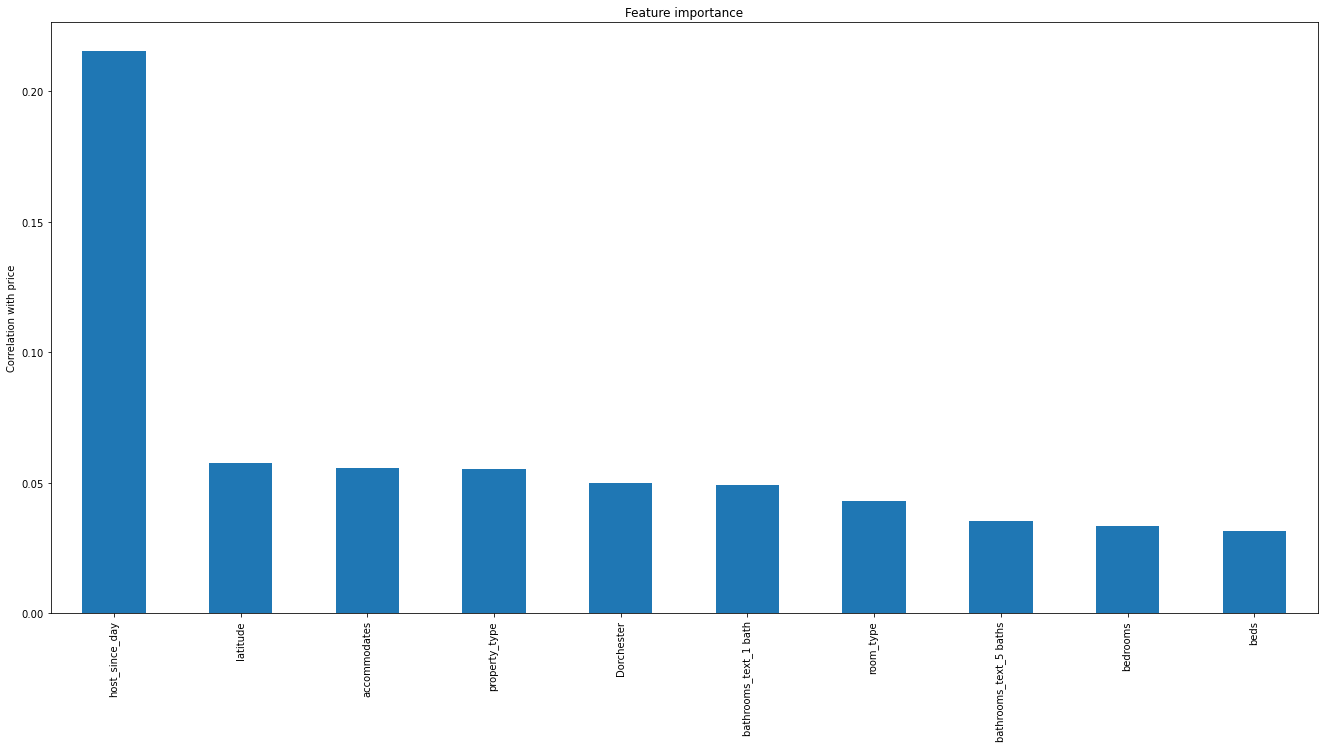

In [32]:
X = Boston_listings.drop(columns=['price'])
y = Boston_listings.price

standard_scaler = preprocessing.StandardScaler()

X = standard_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=12)


rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)


feature_names = [f"{Boston_listings.drop(columns=['price']).columns[i]}" for i in range(X.shape[1])]



max_10_indices = rf.feature_importances_.argsort()[-10:][::-1]

top_features = rf.feature_importances_[max_10_indices]

top_features_names = np.array(feature_names)[max_10_indices]

forest_importances = pd.Series(top_features, index=top_features_names)

forest_importances.sort_values(ascending = False, inplace=True)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importance")
ax.set_ylabel("Correlation with price")
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()

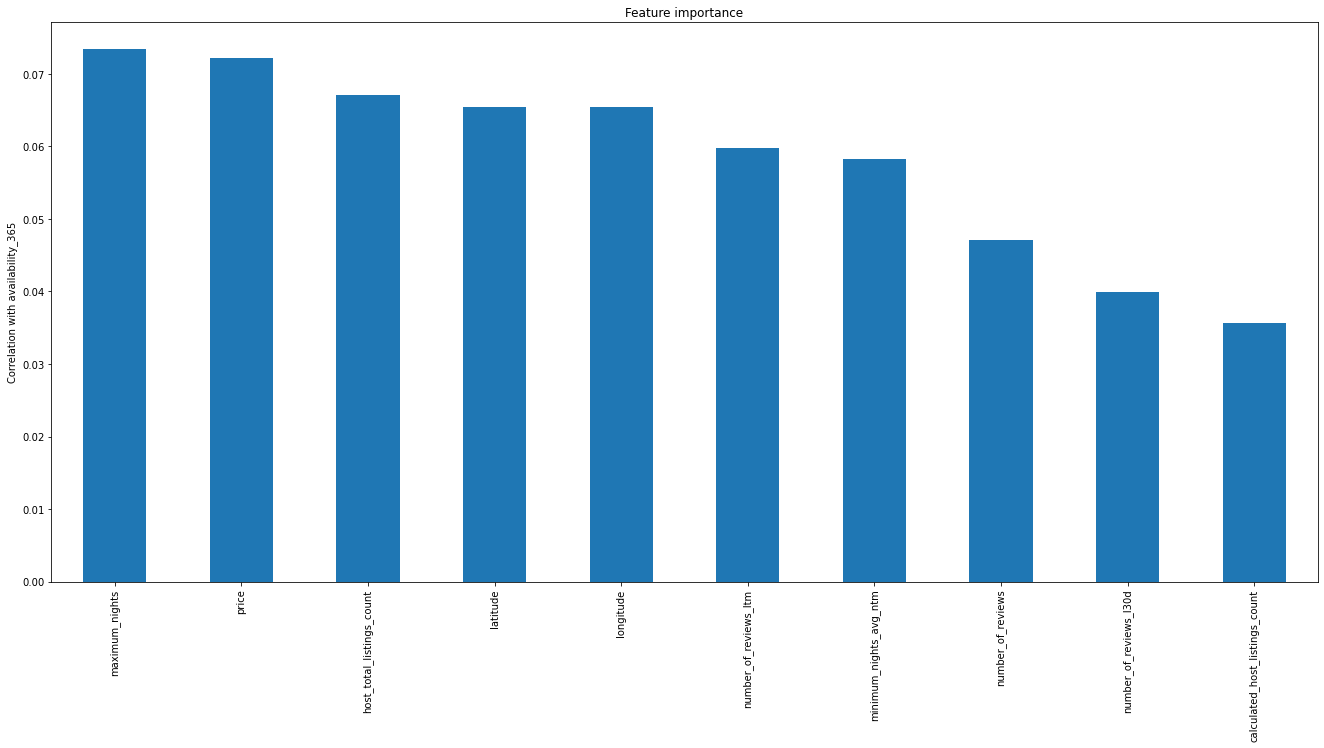

In [33]:
# We are interested in `availability_365` column as it represents avialabilty across the whole year.
# yet we need to drop every column that has `availability` in it.
X = Boston_listings.drop(columns=['availability_365', 'has_availability', 'availability_30',\
                                 'availability_60', 'availability_90'])
y = Boston_listings.availability_365

standard_scaler = preprocessing.StandardScaler()

X = standard_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=12)


rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)


feature_names = [f"{Boston_listings.drop(columns=['availability_365']).columns[i]}" for i in range(X.shape[1])]



max_10_indices = rf.feature_importances_.argsort()[-10:][::-1]

top_features = rf.feature_importances_[max_10_indices]

top_features_names = np.array(feature_names)[max_10_indices]

forest_importances = pd.Series(top_features, index=top_features_names)

forest_importances.sort_values(ascending = False, inplace=True)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importance")
ax.set_ylabel("Correlation with availability_365")
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()

In [34]:
forest_importances

maximum_nights                    0.073409
price                             0.072148
host_total_listings_count         0.067008
latitude                          0.065377
longitude                         0.065362
number_of_reviews_ltm             0.059727
minimum_nights_avg_ntm            0.058319
number_of_reviews                 0.047059
number_of_reviews_l30d            0.039904
calculated_host_listings_count    0.035666
dtype: float64

# As we can see above maximum_nights and price, Location and number_of_reviews_ltm (last twelve months) are the best that correlate to availabilty, and that makes sense  

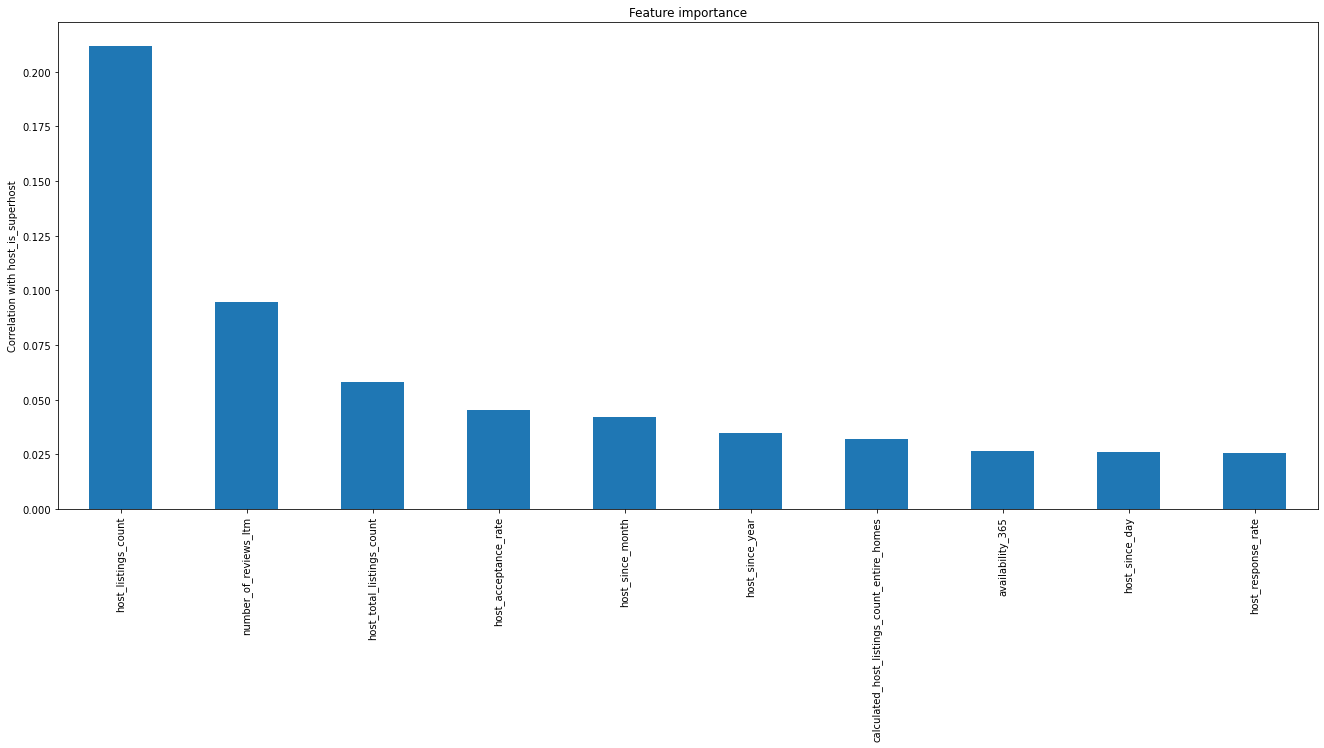

In [35]:
# We are interested in `availability_365` column as it represents avialabilty across the whole year.
# yet we need to drop every column that has `availability` in it.
X = Boston_listings.drop(columns=['host_is_superhost'])
y = Boston_listings.host_is_superhost

standard_scaler = preprocessing.StandardScaler()

X = standard_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=12)


rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)


feature_names = [f"{Boston_listings.drop(columns=['host_is_superhost']).columns[i]}" for i in range(X.shape[1])]



max_10_indices = rf.feature_importances_.argsort()[-10:][::-1]

top_features = rf.feature_importances_[max_10_indices]

top_features_names = np.array(feature_names)[max_10_indices]

forest_importances = pd.Series(top_features, index=top_features_names)

forest_importances.sort_values(ascending = False, inplace=True)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importance")
ax.set_ylabel("Correlation with host_is_superhost")
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()

In [36]:
forest_importances

host_listings_count                            0.212014
number_of_reviews_ltm                          0.094906
host_total_listings_count                      0.058033
host_acceptance_rate                           0.045503
host_since_month                               0.042228
host_since_year                                0.034657
calculated_host_listings_count_entire_homes    0.031844
availability_365                               0.026759
host_since_day                                 0.026215
host_response_rate                             0.025582
dtype: float64

In [37]:
X

array([[ 0.33914559, -2.55588007, -0.36830816, ...,  0.21994569,
         0.03292967, -0.5810192 ],
       [ 0.33914559,  0.58145337, -0.36264011, ...,  0.21994569,
         0.03292967, -0.5810192 ],
       [ 0.33914559,  0.58145337, -0.36264011, ...,  0.21994569,
         0.03292967, -0.5810192 ],
       ...,
       [ 0.33914559,  0.53663432, -0.31243741, ...,  0.21994569,
         0.03292967, -0.5810192 ],
       [ 0.33914559,  0.53663432, -0.31243741, ...,  0.21994569,
         0.03292967, -0.5810192 ],
       [ 0.33914559,  0.53663432, -0.31243741, ...,  0.21994569,
         0.03292967, -0.5810192 ]])

In [41]:
Boston_listings['host_since_month']

1       12
2        2
3        2
4        4
5       12
        ..
5180     5
5181     5
5182     5
5183     5
5184     5
Name: host_since_month, Length: 4616, dtype: int64